In [1]:
import argparse
import json
import os
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
import datetime 
from datetime import datetime 
import numpy as np

# Runners
from neurone.runners.detection import BaseDetectionRunner, HeatmapDetectionRunner
from neurone.runners.segmentation import BaseSegmentationRunner
#from neurone.runners.extended import HeatmapExtendedDetectionRunner
from neurone.runners.gridsearch import GridSearchRunner

E2E = {
    "cpu": CPUEngine,
    "gpu": GPUEngine,
    "dp": DPEngine,
    "ddp": DDPEngine,
    "xla": XLAEngine,
}

#args.engine = "cpu"
#args.tracker = "tensorboard"

print('Get current working directory : ', os.getcwd())
config_path = "./configs/endometritis.json"
!cat ./configs/endometritis.json
with open(config_path, "r") as config_file:
        config = json.load(config_file)
        
        
config["data"]["split_info"] = "/home/data-histology/endonuke_data/trainval/split_info.yml"
config["train"]["experiment_name"] = config["train"]["save_dir"] + " " + config["train"]["experiment_name"]  + " " + str(datetime.now())
#whether to overwrite the model or not
#config["train"]["verbose"] = True
#config["train"]["overwrite"] = True
config["train"]["deterministic"] = False
config["train"]["seed"] = 42
config["train"]["checkpoints_dir"] = "checkpoints"
config["train"]["logging_dir"] = "logs"
config['train']['tracker'] = "tensorboard"
config["train"]["engine"] = "cpu"
if config["train"]["deterministic"]:
    torch.use_deterministic_algorithms(config["train"]["deterministic"])
logging_dir = os.path.join(config["train"]["save_dir"], config["train"]["experiment_name"])
    
runner = globals()[config["model"]["runner"]](engine=E2E["cpu"](
    log_with="tensorboard", logging_dir=logging_dir), config=config)
        

Get current working directory :  /home/alexmak123/neurone
{
    "model": {
        "runner": "HeatmapDetectionRunner",
        "model_name": "HeatmapDetector",
        "model_kwargs": {
            "backbone": "UnetPlusPlus",
            "encoder_name": "resnet50",
            "encoder_depth": 5,
            "encoder_weights": "imagenet",
            "in_channels": 3,
            "classes": 2,
            "activation": null,
            "min_peak_value": 0.1,
            "pooling_scale": 13,
            "out_image_shape": [
                1024,
                1024
            ],
            "supression_range": 9.86
        },
        "weigths_path": "/home/alexmak123/neurone/experiments/endonet_v1/epoch_93.pth",
        "class_separator": null,
        "class_labels_map": {
            "0": 0,
            "1": 1,
            "2": 0
        },
        "input_shape": [
            1024,
            1024
        ],
        "extractor_params": {
            "pooling_scale": 11,
         

In [2]:
# Specify Model
runner._setup_model()
runner.model.eval()

HeatmapDetector(
  (heatmap_model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [6]:
#some transformations for propper data fromat
import matplotlib.pyplot as plt
import albumentations as A
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
alb_transforms = A.Compose([A.augmentations.Resize(1024, 1024)])

#Download our tile
%cd ../test_cappa_koef/validation_slides/
print('Get current working directory : ', os.getcwd())
directory_in_str = "/home/alexmak123/test_cappa_koef/validation_slides/"

import cv2
from PIL import Image

def import_tiles_from_directory_and_convert_them (directory_in_str):
    directory = os.fsencode(directory_in_str)
    converted_images = []
    #i = 1
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".png"): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            #print (myTile.shape)
            #plt.subplot(3, 3, i)
            #plt.imshow(myTile)
            converted_images.append(myTile)
            #i += 1
            #if (i > 3):
            #    return np.array(converted_images)
            continue
        else:
            continue
        
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (directory_in_str)
print (converted_images.shape)
#print (converted_images)

/home/alexmak123/test_cappa_koef/validation_slides
Get current working directory :  /home/alexmak123/test_cappa_koef/validation_slides
(5, 1024, 1024, 3)


In [7]:
import sys


#our data to tensor
image_torch = torch.tensor(converted_images)
print (image_torch.shape)

#image_torch = torch.unsqueeze(image_torch, 0)
image_torch = image_torch.permute(0, 3, 1, 2) 
image_torch = image_torch.float()

#here should be meanstd values, counted for this picture, but with counted meanstd it doesn't classify properly on stroma and epithelium. That's why we use standard meanstd values

#!!!NOTE: ASK ABOUT THIS!!!
#config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2] = (170, 154, 144)
#config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2] = (63, 69, 71)
image_torch -= torch.tensor([config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2]]).reshape(-1, 1, 1)
image_torch /= torch.tensor([config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2]]).reshape(-1, 1, 1)
    

#np.set_printoptions(threshold=sys.maxsize)
print ("Keypoints of all tiles : \n")
keypoints = runner.model(image_torch)["keypoints"]
print (keypoints, "\n")
print ("Confidences of all tiles : \n")
confidences = runner.model(image_torch)["confidences"]
print (confidences, "\n")

#x_coords = keypoints.x_coords()
#y_coords = keypoints.y_coords()
#classes = keypoints.classes()

torch.Size([5, 1024, 1024, 3])
Keypoints of all tiles : 

[[  0. 561. 376.   0.]
 [  0. 692. 650.   0.]
 [  0. 728. 432.   0.]
 ...
 [  4.   0. 470.   0.]
 [  4. 645. 732.   0.]
 [  4. 412. 651.   0.]] 

Confidences of all tiles : 

[1.4599827e-04 3.7351419e-04 4.8058730e-04 ... 7.5793058e-01 7.8109467e-01
 7.9200506e-01] 



In [8]:
#split keypoints of all tiles to array of selected colums with x_coords, y_coords and classes of all tiles
#later we would not need this, but for demonstration that everything works properly we will add these "tiles split"
j = 0
selected_columns_array = []
for index_tile in range(converted_images.shape[0]):
    selected_columns = []
    while (j < keypoints.shape[0] and keypoints[j][0] == index_tile):
        selected_columns.append([int(keypoints[j][1]), int(keypoints[j][2]), int(keypoints[j][3])])
        j += 1
    selected_columns_array.append(np.array(selected_columns))
    
print (np.array(selected_columns_array, dtype=object))

[array([[ 561,  376,    0],
        [ 692,  650,    0],
        [ 728,  432,    0],
        ...,
        [ 624, 1021,    0],
        [  64,   74,    0],
        [  20,  318,    0]]) array([[ 844,  689,    0],
                                    [ 614,  180,    0],
                                    [ 848,  732,    0],
                                    ...,
                                    [ 564,  506,    0],
                                    [ 577,  774,    0],
                                    [ 401, 1007,    0]])
 array([[180, 789,   0],
        [715, 569,   0],
        [210, 183,   0],
        ...,
        [270,  47,   0],
        [730, 477,   0],
        [370, 132,   0]]) array([[1004,  853,    0],
                                 [ 686,  858,    0],
                                 [ 474,  484,    0],
                                 ...,
                                 [ 799,  141,    0],
                                 [ 398,  898,    0],
                            

Get current working directory :  /home/alexmak123/test_cappa_koef/validation_slides


ValueError: num must be 1 <= num <= 4, not 5

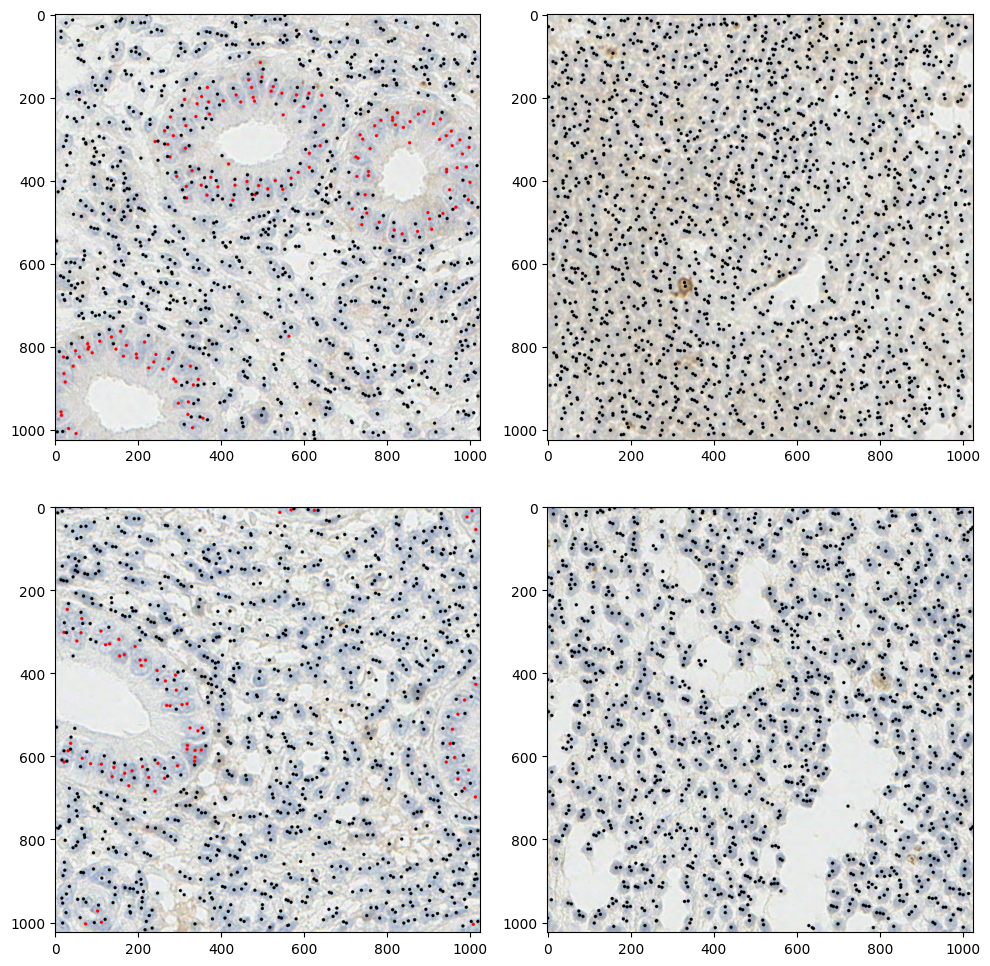

In [9]:
#make pictures
#Set the figure size
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

print('Get current working directory : ', os.getcwd())
directory_in_str = "/home/alexmak123/test_cappa_koef/validation_slides/"


i = 1
index_tile = 0
for file in os.listdir(directory_in_str):
    plt.subplot(2, 2, i)
    i += 1
    filename = os.fsdecode(file)
    for dot_center in selected_columns_array[index_tile]:
        if (dot_center[2] == 0):
            cv2.circle(converted_images[index_tile], (dot_center[0], dot_center[1]), 4, (0,0,0), -1)
        if (dot_center[2] == 1):
            cv2.circle(converted_images[index_tile], (dot_center[0], dot_center[1]), 4, (255, 0, 0), -1)
        
    PIL_image = Image.fromarray(converted_images[index_tile].astype('uint8'), 'RGB')
    #PIL_image.save(os.path.join(os.getcwd(), filename))
    index_tile += 1
    plt.imshow(PIL_image)

In [7]:
#right now we will count the color of our stromas (cutting out the center) (stromas are on the left picture above and they are colored in black)
#note : first we get rgb colors and then we should convert them to hsv (to get rid of the Blue part, so that we can define brown)
#in this function we have selected_colums, which are our keypoints; cell_size which is a size of our sell; and cut_center_size which is a size of a square that we are cutting from our original cell
import math

def pixel_values_of_the_toruses(selected_columns, myTile, cell_size, cut_center_size = 0):
    if (cut_center_size > cell_size):
        raise ValueError("your cut_center_size is more than a cell_size")
    
    list_of_cells = []
    for dot_center in selected_columns:
        #we want only stromas
        if (dot_center[2] == 0): 
            x = dot_center[0].astype(int)
            y = dot_center[1].astype(int)
        
            #here we count max bounds of i and j for cell size and cut_center_size
        
            #!!!
            max_bound_for_cell = cell_size//2 
            max_bound_for_cut_center = cut_center_size//2
            #!!!
        
            i, j = -max_bound_for_cell, -max_bound_for_cell
            myCell = []
            #print ("new pair " + str(cell_size) + "x" + str(cell_size) + " : \n")
            while (x+i >= 0 and x+i < 512 and i <= max_bound_for_cell):
                j = -max_bound_for_cell
                while (y+j >= 0 and y+j < 512 and j <= max_bound_for_cell):
                    if (i >= -max_bound_for_cut_center and i <= max_bound_for_cut_center and j >= -max_bound_for_cut_center and j <= max_bound_for_cut_center):
                        j += 1
                        continue
                    #print(i, j)
                    #print(myTile[x+i][y+j])
                    myCell.append(myTile[x+i][y+j])
                    j += 1
                i += 1
                
            #print(np.array(myCell))
            if(cut_center_size == 0):
                myCell.append(myTile[x][y])
            if (len(myCell) != 0):
                list_of_cells.append(myCell)
            
    return np.array(list_of_cells, dtype = object)


In [8]:
#so we have a numpy array of numpy arrays of pixel values of the torus of stroma for each dot_center in selected_columns
tors_pixel_values_array = []
for index_tile in range(converted_images.shape[0]):
    tors_pixel_values = pixel_values_of_the_toruses(selected_columns_array[index_tile], converted_images[index_tile], 19, 5)
    tors_pixel_values_array.append(tors_pixel_values)
     
#print (np.array(tors_pixel_values_array, dtype = object))

In [2]:
#now lets count the mean color in RGB for each tile and each torus of the stroma in this tile; convert mean rgb values to hsv and take only tors that have brown color
import colorsys

def count_brown_tors_for_each_tile (tors_pixel_values):
    #list_of_brown_tors = []
    hsv_values_of_brown_tors = []
    for elem in tors_pixel_values:
        rgb_mean = np.mean(elem, axis = 0)
        hsv = colorsys.rgb_to_hsv(rgb_mean[0] / float(255), rgb_mean[1] / float(255), rgb_mean[2] / float(255))
        hsv = (int(hsv[0] * 179), int(hsv[1] * 255), int(hsv[2] * 255))
        #if hue is >5 and <90 and if value < 198 then we have a brown spectre color
        if (hsv[0] >= 10 and hsv[0] <= 20 and hsv[2] <= 230):
            #print(hsv)
            hsv_values_of_brown_tors.append(hsv)
            #list_of_brown_tors.append(elem)
    return (np.array(hsv_values_of_brown_tors))

list_of_brown_tors = []
for tors_pixel_values in tors_pixel_values_array:
    list_of_brown_tors.append(count_brown_tors_for_each_tile(tors_pixel_values))
print(np.array(list_of_brown_tors, dtype = object))


NameError: name 'tors_pixel_values_array' is not defined